In [1]:
#!/usr/bin/env python
# coding: utf-8

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import statistics
from scipy.ndimage.filters import gaussian_filter1d

import chart_simple as chs
import co_main as com

import time
start = time.time()

In [2]:
theme = 'mono'

In [3]:
plt.rcParams['figure.max_open_warning'] = 0
plt.rcParams['figure.autolayout'] = True

today = date.today().strftime('%Y-%m-%d')

In [4]:
utc_today = com.utc_convert(today)
year = today[0:4]
print(year,today,utc_today)

2021 2021-01-08 44204


In [5]:
on_db = pd.read_csv(f'datasets/{year}/conposcovidloc.csv')
on_age = pd.read_csv(f'datasets/{year}/age_groups_ontario.csv')
previous = pd.read_csv(f'datasets/{year}/outcomes.csv')

In [6]:
print(previous)

        outcome   count  pop%
0         Total  208394  1.00
1      Resolved  175309  0.84
2  Not Resolved   28203  0.14
3         Fatal    4882  0.02


In [7]:
url = 'https://en.wikipedia.org/wiki/Demographics_of_Ontario'

In [8]:
on_db['utc'] = on_db['Case_Reported_Date'].apply(lambda x: com.utc_convert_batch(x))

In [9]:
total_cases = on_db['Accurate_Episode_Date'].count()
resolved = on_db[on_db['Outcome1'] == 'Resolved']['Outcome1'].count()
not_resolved = on_db[on_db['Outcome1'] == 'Not Resolved']['Outcome1'].count()
fatalities = on_db[on_db['Outcome1'] == 'Fatal']['Outcome1'].count()

print(total_cases,'total cases\n',
      resolved,'resolved\n',
      not_resolved,'not resolved\n',
      fatalities,'fatalities\n',
      'as of today\n', today,'\n')

208394 total cases
 175309 resolved
 28203 not resolved
 4882 fatalities
 as of today
 2021-01-08 



In [10]:
print(total_cases-previous.at[0,'count'])

0


In [11]:
testing = com.get_pie(on_db,'Outcome1',total_cases,'outcome-total_cases')
testing

,outcome,count,pop%
0,Resolved,175309,0.84
1,Not Resolved,28203,0.14
2,Fatal,4882,0.02


In [12]:
'''daily_deaths = []
i = 0
for date in on_db['Case_Reported_Date'].sort_values().dropna().unique():
    
    previous_dates = on_db[on_db['Case_Reported_Date'] < date]
    pc = previous_dates['Case_Reported_Date'].count()
    previous_dates = com.get_pie(previous_dates,'Outcome1',pc,'outcome-total_cases')
    
    pf = current_date
    if 'Fatal' in pf['outcome'].values:
        pr = pf[pf['outcome'] == 'Fatal']['count'].values[0]
    else:
        pr = 0
    
    current_date = on_db[on_db['Case_Reported_Date'] <= date]
    tc = current_date['Case_Reported_Date'].count()
    current_date = com.get_pie(current_date,'Outcome1',tc,'outcome-total_cases')
    
    cf = current_date
    if 'Fatal' in cf['outcome'].values:
        cr = cf[cf['outcome'] == 'Fatal']['count'].values[0]
    else:
        cr = 0
    i += 1
    if i == 1:
        pr = 0
        
    #print(date,' ',cr - pr)'''

"daily_deaths = []\ni = 0\nfor date in on_db['Case_Reported_Date'].sort_values().dropna().unique():\n    \n    previous_dates = on_db[on_db['Case_Reported_Date'] < date]\n    pc = previous_dates['Case_Reported_Date'].count()\n    previous_dates = com.get_pie(previous_dates,'Outcome1',pc,'outcome-total_cases')\n    \n    pf = current_date\n    if 'Fatal' in pf['outcome'].values:\n        pr = pf[pf['outcome'] == 'Fatal']['count'].values[0]\n    else:\n        pr = 0\n    \n    current_date = on_db[on_db['Case_Reported_Date'] <= date]\n    tc = current_date['Case_Reported_Date'].count()\n    current_date = com.get_pie(current_date,'Outcome1',tc,'outcome-total_cases')\n    \n    cf = current_date\n    if 'Fatal' in cf['outcome'].values:\n        cr = cf[cf['outcome'] == 'Fatal']['count'].values[0]\n    else:\n        cr = 0\n    i += 1\n    if i == 1:\n        pr = 0\n        \n    #print(date,' ',cr - pr)"

In [13]:
'''daily_deaths = []
for date in on_db['Case_Reported_Date'].sort_values().dropna().unique():
    previous_dates = on_db[(on_db['Case_Reported_Date'] < date) & (on_db['Outcome1'] == 'Fatal')]['Outcome1'].count()
    current_date = on_db[(on_db['Case_Reported_Date'] <= date) & (on_db['Outcome1'] == 'Fatal')]['Outcome1'].count()
    daily_deaths.append(current_date - previous_dates)'''

"daily_deaths = []\nfor date in on_db['Case_Reported_Date'].sort_values().dropna().unique():\n    previous_dates = on_db[(on_db['Case_Reported_Date'] < date) & (on_db['Outcome1'] == 'Fatal')]['Outcome1'].count()\n    current_date = on_db[(on_db['Case_Reported_Date'] <= date) & (on_db['Outcome1'] == 'Fatal')]['Outcome1'].count()\n    daily_deaths.append(current_date - previous_dates)"

In [14]:
on_cases = com.get_cases(on_db,total_cases)
on_cases

,age_group,female,male,unspecified,transgender,total,case%,f%,m%,fatal-f,fatal-m,fatal-u,fatal-t,fatal-total,fatal%
0,20s,20313.0,22702.0,260.0,4.0,43279.0,0.21,0.47,0.52,2.0,5.0,0.0,0.0,7.0,0.00
1,30s,16035.0,16475.0,205.0,4.0,32719.0,0.16,0.49,0.50,2.0,12.0,0.0,0.0,14.0,0.00
2,50s,15954.0,14409.0,136.0,3.0,30502.0,0.15,0.52,0.47,55.0,91.0,0.0,0.0,146.0,0.03
3,40s,15659.0,13830.0,184.0,5.0,29678.0,0.14,0.53,0.47,12.0,29.0,0.0,0.0,41.0,0.01
4,<20,12840.0,13961.0,204.0,5.0,27010.0,0.13,0.48,0.52,1.0,0.0,0.0,0.0,1.0,0.00
5,60s,9385.0,10095.0,83.0,2.0,19565.0,0.09,0.48,0.52,147.0,266.0,0.0,0.0,413.0,0.09
6,70s,5228.0,5283.0,54.0,1.0,10566.0,0.05,0.49,0.50,345.0,542.0,0.0,0.0,887.0,0.18
7,80s,5686.0,3487.0,70.0,0.0,9243.0,0.04,0.62,0.38,910.0,842.0,0.0,0.0,1752.0,0.36
8,90s,4224.0,1501.0,59.0,0.0,5784.0,0.03,0.73,0.26,1050.0,529.0,0.0,0.0,1579.0,0.33
9,UNKNOWN,4.0,4.0,1.0,0.0,9.0,0.00,0.44,0.44,0.0,0.0,0.0,0.0,0.0,0.00


In [15]:
fatal = on_cases[['age_group','fatal-f','fatal-m','fatal-t','fatal-u','fatal-total','fatal%']]
fatal = fatal.sort_values(by='fatal-total',ascending=False)
fatal.to_csv(f'datasets/{year}/fatal.csv',index=False)
print(total_cases - int(on_cases['total'].sum()),'cases not assigned to any age group')

39 cases not assigned to any age group


In [16]:
all_cases = com.all_cases_count(on_db)
#all_cases['daily_deaths'] = daily_deaths

In [17]:
all_cases

,date,sick,resolved,fatal,count,days,utc
0,2020-01-23,0,2,0,2,0,43853
1,2020-01-24,0,1,0,1,1,43854
2,2020-01-30,0,1,0,1,2,43860
3,2020-02-21,0,1,0,1,3,43882
4,2020-02-25,0,1,0,1,4,43886
...,...,...,...,...,...,...,...
316,2021-01-03,2960,269,13,3242,316,44199
317,2021-01-04,2878,222,3,3103,317,44200
318,2021-01-05,3002,149,6,3157,318,44201
319,2021-01-06,3287,89,2,3378,319,44202


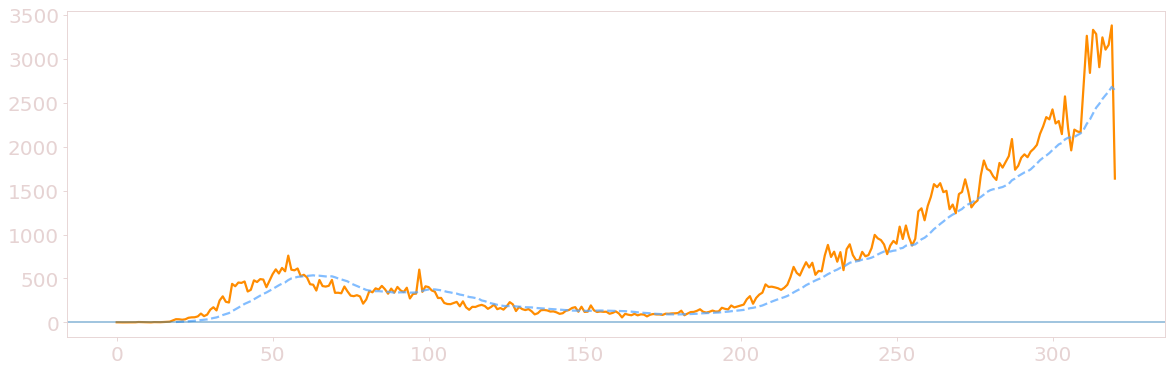

In [18]:
filename = f'static/images/graph/ontario-daily_cases_count.png'
chs.graph_frame(all_cases['days'],all_cases['count'],theme,filename,figsize = (15,5),font=18,save=1,rolling=20,legend=0,legend_title='',ticks=0,tr=0)

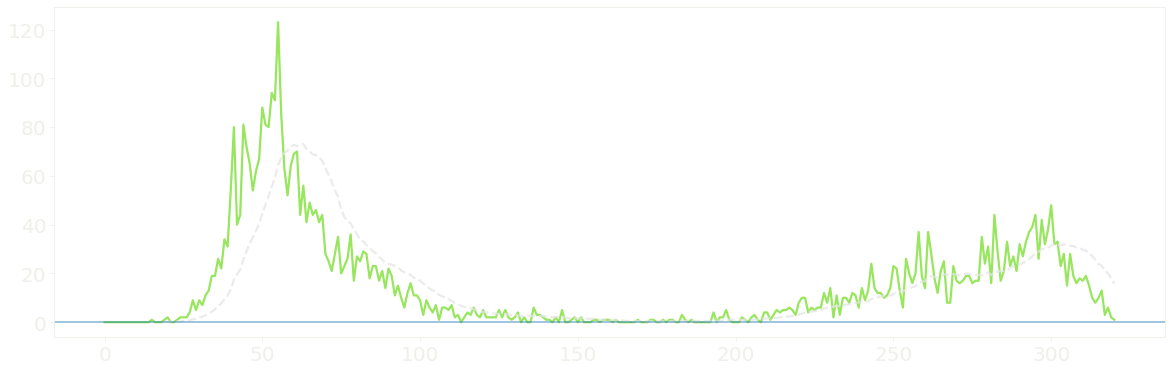

In [19]:
filename = f'static/images/graph/ontario-daily_deaths_count.png'
chs.graph_frame(all_cases['days'],all_cases['fatal'],'arcade',filename,figsize = (15,5),font=18,save=1,rolling=20,legend=0,legend_title='',ticks=0,tr=0)

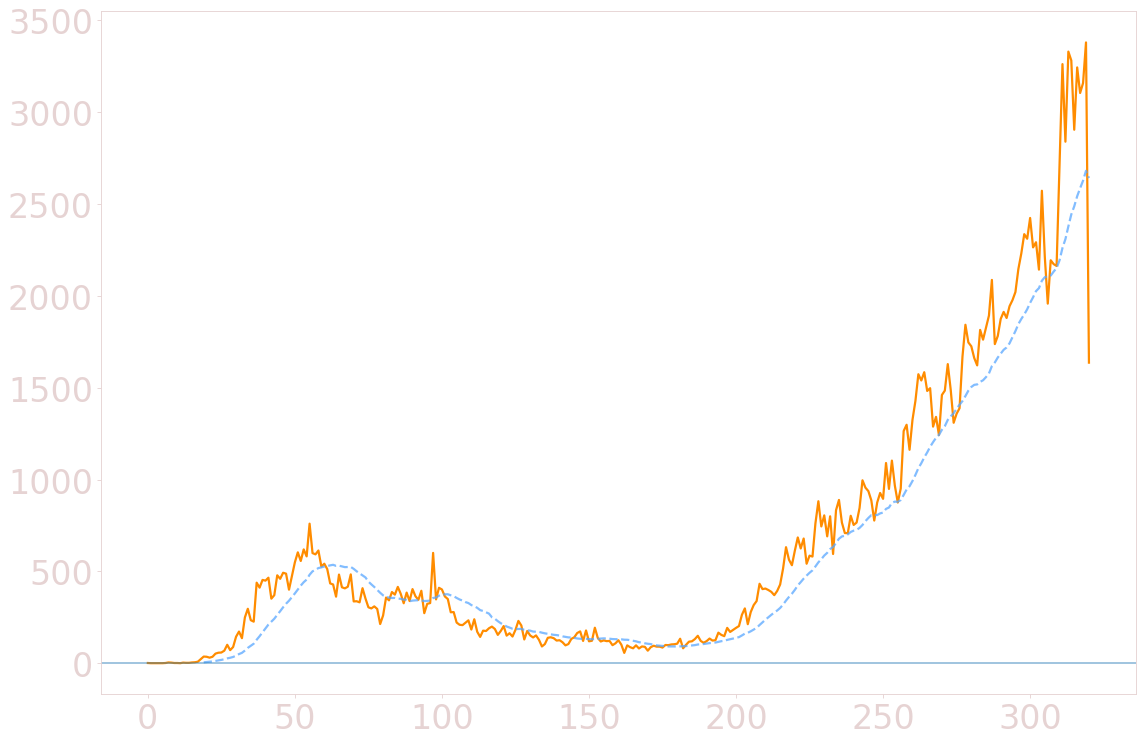

In [20]:
filename = f'static/images/graph/ontario-daily_cases_count_s.png'
chs.graph_frame(all_cases['days'],all_cases['count'],theme,filename,figsize = (15,10),font=30,save=1,rolling=20,legend=0,legend_title='',ticks=0,tr=0)

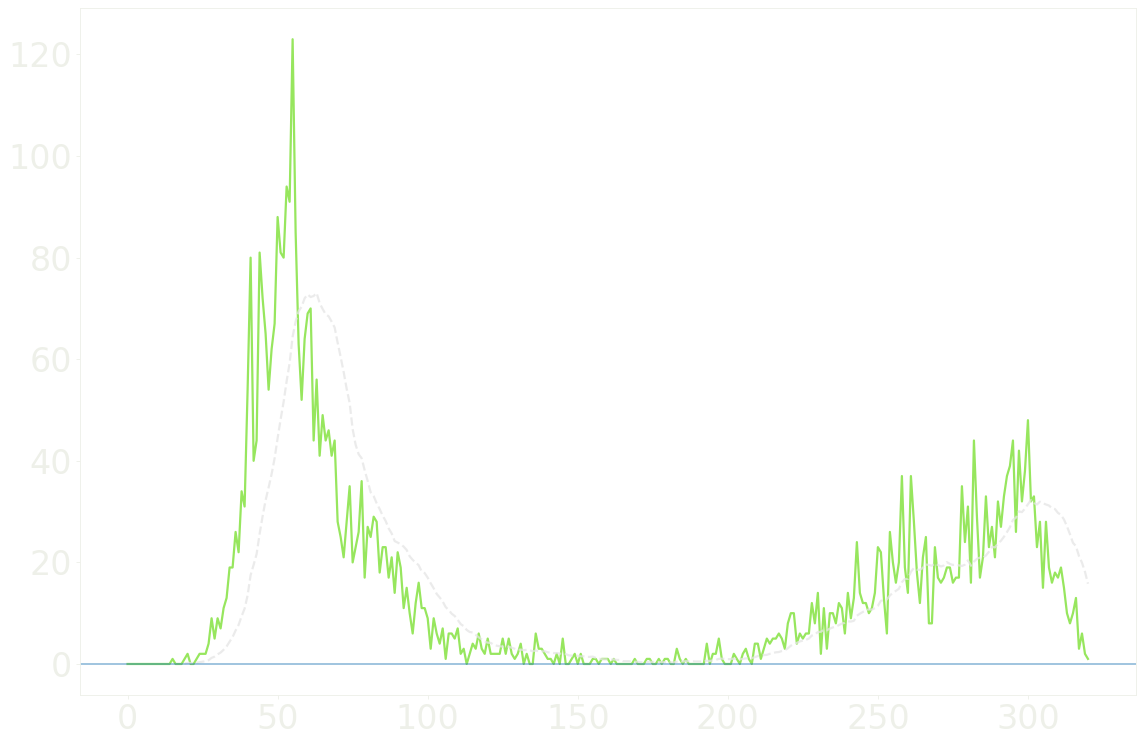

In [21]:
filename = f'static/images/graph/ontario-daily_deaths_count_s.png'
chs.graph_frame(all_cases['days'],all_cases['fatal'],'arcade',filename,figsize = (15,10),font=30,save=1,rolling=20,legend=0,legend_title='',ticks=0,tr=0)

<Figure size 432x288 with 0 Axes>

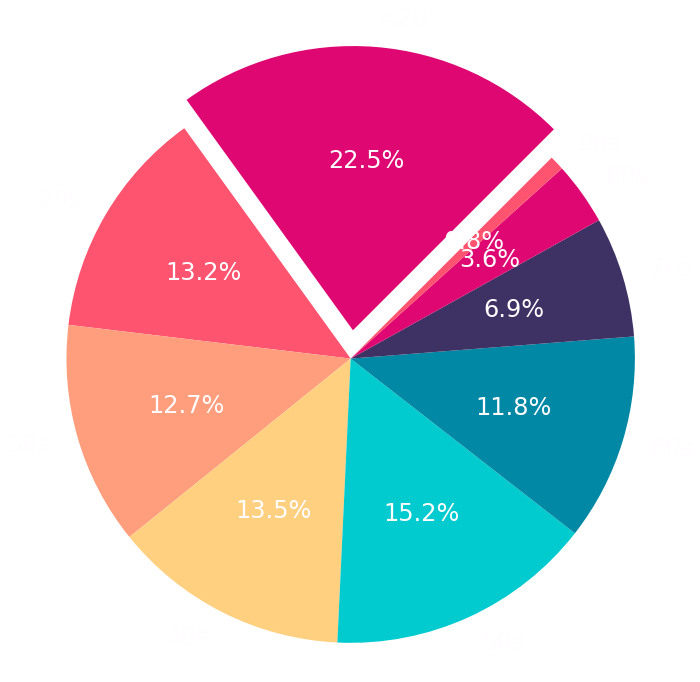

In [22]:
filename = f'static/images/pie/ontario-age_groups.png'
chs.graph_pie(on_age[:-1],'age_groups','count','title',filename,colour='neon',figsize=10,font=24,save=1,tr=0)

<Figure size 432x288 with 0 Axes>

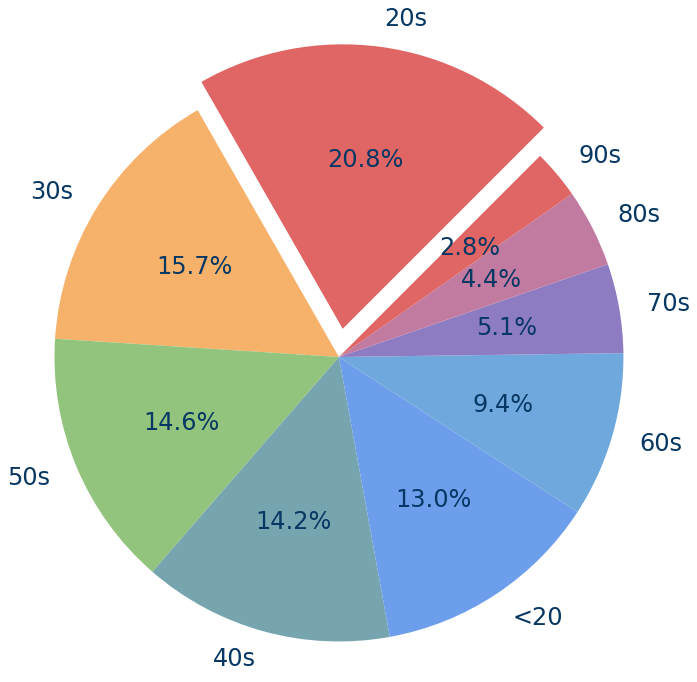

In [23]:
age_groups = com.get_pie(on_db,'Age_Group',total_cases,'')
filename = f'static/images/pie/all_ages-total_cases'
chs.graph_pie(age_groups,'age_group','count','title',filename,colour='geegle',figsize=10,font=24,save=1,tr=0)

In [24]:
print('Past ',16,' days')

Past  16  days


In [25]:
utc_today

44204

<Figure size 432x288 with 0 Axes>

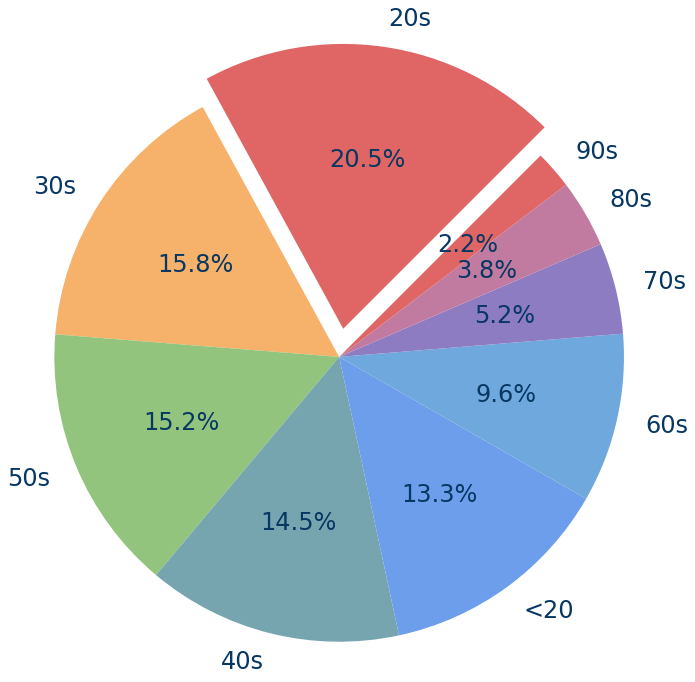

In [49]:
recent_cases = on_db[(on_db['utc'] >= utc_today - 16)]
recent_cases = recent_cases.sort_values(by='utc',ascending=False)
recent_groups = com.get_pie(recent_cases,'Age_Group',total_cases,'cases_by_age-16-days')
filename = f'static/images/pie/cases_by_age-16-days'
chs.graph_pie(recent_groups,'age_group','count','title',filename,colour='geegle',figsize=10,font=24,save=1,tr=0)

In [50]:
recent_cases_count = all_cases.tail(16)
recent_cases_count = recent_cases_count.reset_index()
recent_cases_count.pop('index')
recent_cases_count['days'] = recent_cases_count['date'].apply(lambda x: x[-2:])
print(recent_cases_count)

          date  sick  resolved  fatal  count days    utc
0   2020-12-23    23      2171     15   2209   23  44188
1   2020-12-24    61      1868     28   1957   24  44189
2   2020-12-25   285      1889     19   2193   25  44190
3   2020-12-26   462      1694     16   2172   26  44191
4   2020-12-27   803      1341     18   2162   27  44192
5   2020-12-28  1220      1482     17   2719   28  44193
6   2020-12-29  1856      1385     19   3260   29  44194
7   2020-12-30  1837       986     15   2838   30  44195
8   2020-12-31  2550       768     10   3328   31  44196
9   2021-01-01  2684       588      8   3280   01  44197
10  2021-01-02  2495       398     10   2903   02  44198
11  2021-01-03  2960       269     13   3242   03  44199
12  2021-01-04  2878       222      3   3103   04  44200
13  2021-01-05  3002       149      6   3157   05  44201
14  2021-01-06  3287        89      2   3378   06  44202
15  2021-01-07  1624        11      1   1636   07  44203


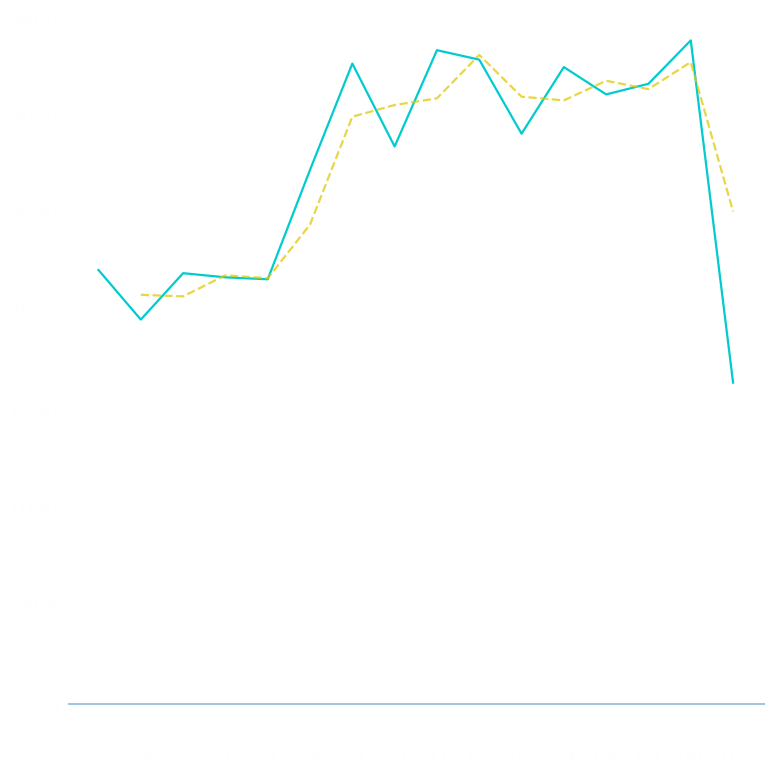

In [28]:
filename = f'static/images/graph/ontario-recent_daily_cases_count.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['count'],'neon',filename,figsize = (10,10),font=18,save=1,rolling=2,legend=0,legend_title='',ticks=1,tr=0)

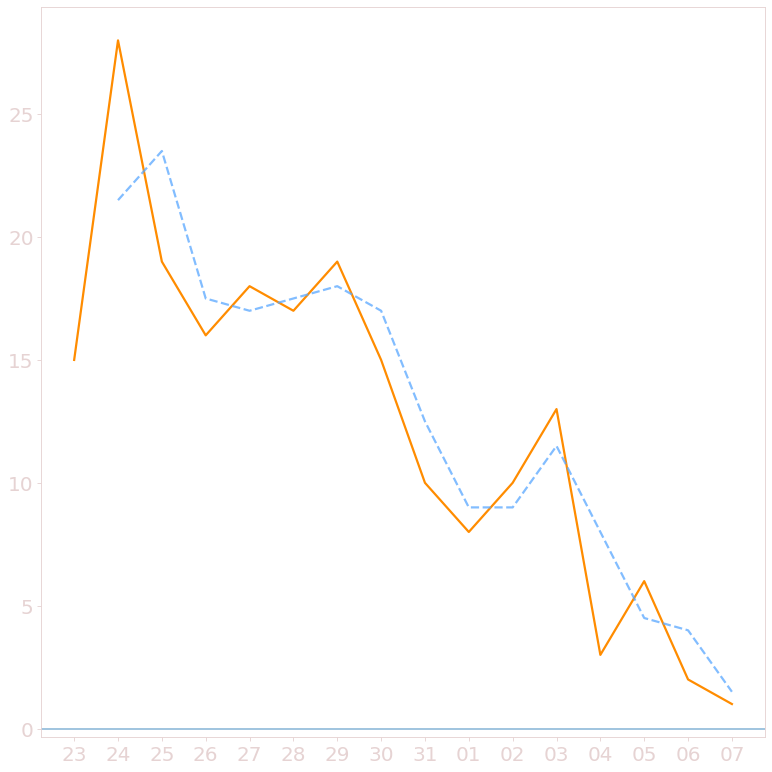

In [29]:
filename = f'static/images/graph/ontario-recent_daily_deaths_count.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['fatal'],theme,filename,figsize = (10,10),font=18,save=1,rolling=2,legend=0,legend_title='',ticks=1,tr=0)

In [30]:
female_16 = recent_cases[recent_cases['Client_Gender'] == 'FEMALE']
male_16 = recent_cases[recent_cases['Client_Gender'] == 'MALE']
transgender_16 = recent_cases[recent_cases['Client_Gender'] == 'TRANSGENDER']
female_16_count = com.utc_count(female_16)
male_16_count = com.utc_count(male_16)
transgender_16_count = com.utc_count(transgender_16)

a,b,c,d = [],[],[],[]
for date in recent_cases_count['utc'].unique():
    actual = on_db[on_db['utc'] == date]['Case_Reported_Date'].values[0]
    try:
        m = male_16_count[male_16_count['date'] == date]['count'].values[0]
    except:
        m = 0
    try:
        f = female_16_count[female_16_count['date'] == date]['count'].values[0]
    except:
        f = 0
    try:
        t = transgender_16_count[transgender_16_count['date'] == date]['count'].values[0]
    except:
        t = 0
    a.append(m)
    b.append(f)
    c.append(t)
    d.append(actual)
recent_cases_count['m_count'] = a
recent_cases_count['f_count'] = b
recent_cases_count['t_count'] = c
recent_cases_count['actual_date'] = d
recent_cases_count = recent_cases_count.dropna()

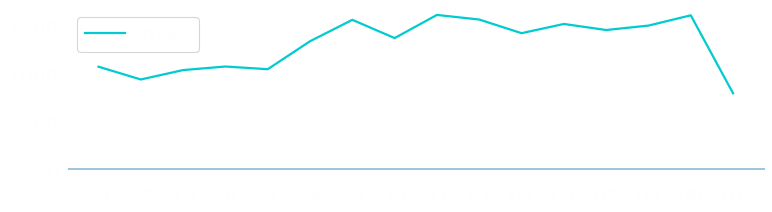

In [31]:
#plt.savefig(filename, facecolor=FACE,edgecolor=EDGE)
filename = f'static/images/graph/16-days-total_count-male.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['m_count'],'neon',filename,figsize = (10,3),font=18,save=1,rolling=0,legend=1,legend_title='male',ticks=1,tr=0)

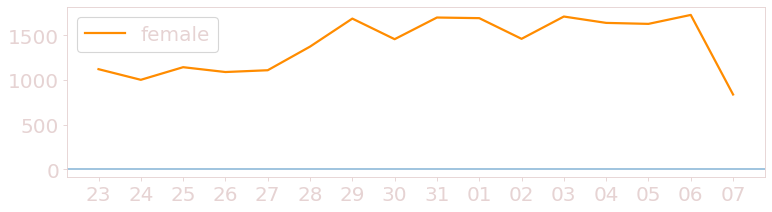

In [32]:
filename = f'static/images/graph/16-days-total_count-female.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['f_count'],theme,filename,figsize = (10,3),font=18,save=1,rolling=0,legend=1,legend_title='female',ticks=1,tr=0)

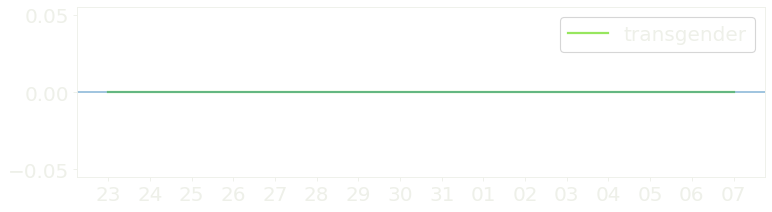

In [33]:
filename = f'static/images/graph/16-days-total_count-transgender.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['t_count'],'arcade',filename,figsize = (10,3),font=18,save=1,rolling=0,legend=1,legend_title='transgender',ticks=1,tr=0)

In [34]:
#plt.savefig(filename, facecolor=FACE,edgecolor=EDGE)
gender_groups = com.get_pie(on_db,'Client_Gender',total_cases,'gender-total_cases')
#filename = f'static/images/pie/gender-total_cases'
#chs.graph_pie(gender_groups,'client_gender','count','title',filename,colour=theme,figsize=10,font=24,save=1,tr=0)

In [35]:
gender_groups_sum = gender_groups['count'].sum()
gender_groups['pop%'] = round(gender_groups['count'] / gender_groups_sum,4)*100

In [36]:
gender_groups.to_csv(f'datasets/{year}/gender_infected.csv',index=False)

outcomes = com.get_pie(on_db,'Outcome1',total_cases,'outcome-total_cases')
#filename = f'static/images/pie/outcome-total_cases'
#chs.graph_pie(outcomes,'outcome','count','title',filename,colour=theme,figsize=10,font=24,save=1,tr=0)

In [37]:
outcomes.loc[-1] = ['Total',total_cases,1.0]
outcomes.index = outcomes.index + 1
outcomes = outcomes.sort_index()
outcomes.to_csv(f'datasets/{year}/outcomes.csv',index=False)
print('\n',outcomes)
print('\n',previous)
print('\n',outcomes.at[0,'count'] - previous.at[0,'count'])


         outcome   count  pop%
0         Total  208394  1.00
1      Resolved  175309  0.84
2  Not Resolved   28203  0.14
3         Fatal    4882  0.02

         outcome   count  pop%
0         Total  208394  1.00
1      Resolved  175309  0.84
2  Not Resolved   28203  0.14
3         Fatal    4882  0.02

 0


In [38]:
int_lst, flt_lst = [] , []
int_lst.append(int(outcomes.iloc[0]['count'] - previous.iloc[0]['count']))
int_lst.append(int(outcomes.at[1,'count'] - previous.at[1,'count']))
int_lst.append(int(outcomes.at[2,'count'] - previous.at[2,'count']))
int_lst.append(int(outcomes.at[3,'count'] - previous.at[3,'count']))

flt_lst.append(round(int_lst[0] / outcomes.at[0,'count'],4))
flt_lst.append(round(int_lst[1] / outcomes.at[1,'count'],4))
flt_lst.append(round(int_lst[2] / outcomes.at[2,'count'],4))
flt_lst.append(round(int_lst[3] / outcomes.at[3,'count'],4))

In [39]:
change = pd.DataFrame()
change['change'] = int_lst
change['ratio'] = flt_lst

In [40]:
change.to_csv(f'datasets/{year}/change.csv',index=False)

In [41]:
print('\n',change,'\n')
print('fatal check: ',all_cases['fatal'].sum())


    change  ratio
0       0    0.0
1       0    0.0
2       0    0.0
3       0    0.0 

fatal check:  4882


In [42]:
phu_cases = com.get_category_count(on_db,'Reporting_PHU_City',total_cases)
cases_date = com.get_category_count(on_db,'Accurate_Episode_Date',total_cases)
fatal = fatal.dropna()
print(fatal)

  age_group  fatal-f  fatal-m  fatal-t  fatal-u  fatal-total  fatal%
7       80s    910.0    842.0      0.0      0.0       1752.0    0.36
8       90s   1050.0    529.0      0.0      0.0       1579.0    0.33
6       70s    345.0    542.0      0.0      0.0        887.0    0.18
5       60s    147.0    266.0      0.0      0.0        413.0    0.09
2       50s     55.0     91.0      0.0      0.0        146.0    0.03
3       40s     12.0     29.0      0.0      0.0         41.0    0.01
1       30s      2.0     12.0      0.0      0.0         14.0    0.00
0       20s      2.0      5.0      0.0      0.0          7.0    0.00
4       <20      1.0      0.0      0.0      0.0          1.0    0.00
9   UNKNOWN      0.0      0.0      0.0      0.0          0.0    0.00


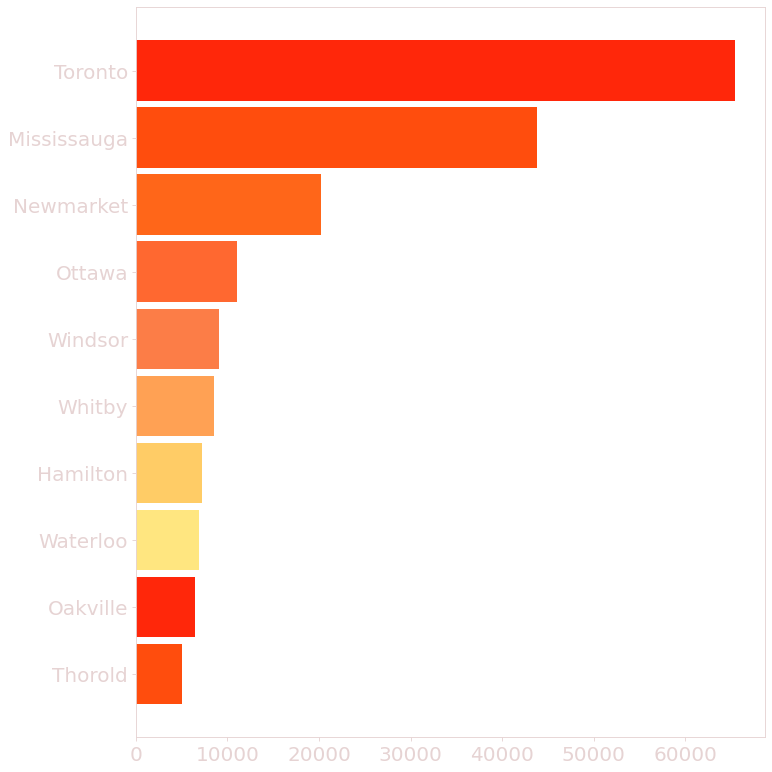

In [43]:
top_10_phu = phu_cases.head(10)
filename = f'static/images/bar/ontario-reporting_phu_city-top10.png'
chs.graph_bar(top_10_phu,'reporting_phu_city','count','title',theme,filename,figsize = (10,10),font=18,save=1,rolling=2,tr=0)

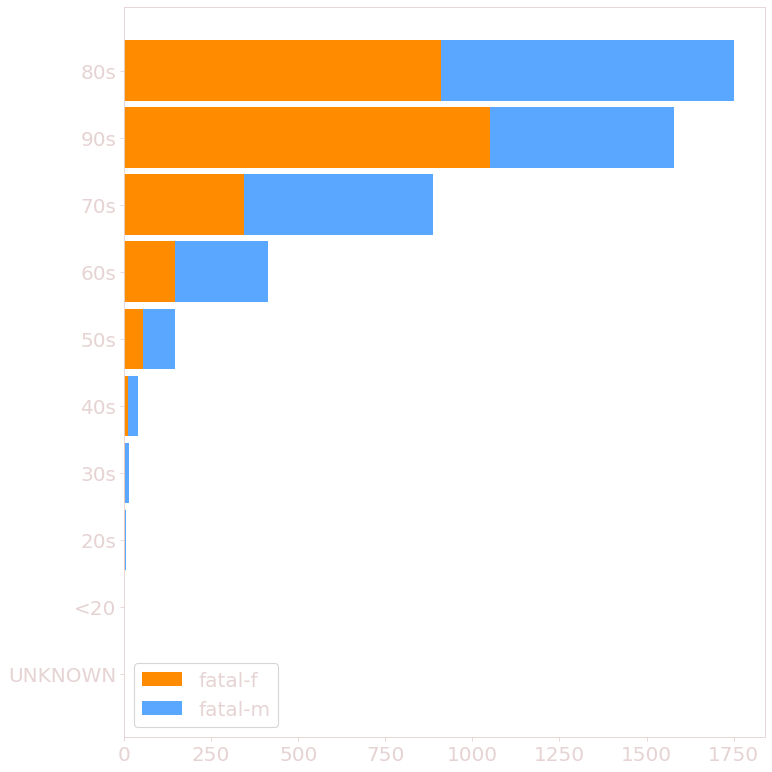

In [44]:
filename = 'static/images/bar/fatalities.png'
chs.graph_bar_stacked(fatal,'age_group','fatal-f','fatal-m','title',theme,filename,figsize = (10,10),font=18,save=1,rolling=2,tr=0)

In [45]:
recent_cases_count = recent_cases_count.dropna()

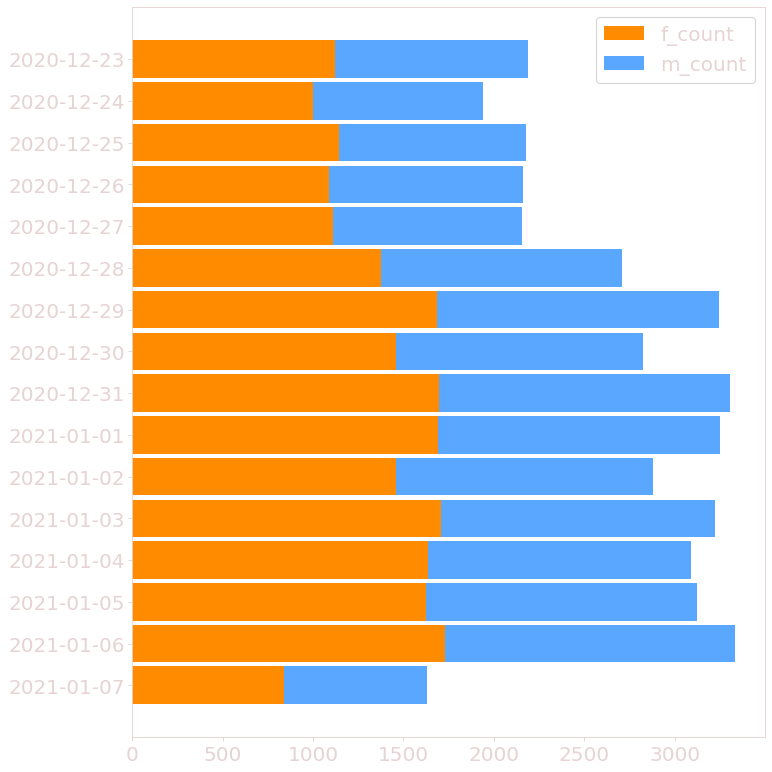

In [46]:
filename = 'static/images/bar/last16day-cases.png'
chs.graph_bar_stacked(recent_cases_count,'actual_date','f_count','m_count','title',theme,filename,figsize = (10,10),font=18,save=1,rolling=2,tr=0)

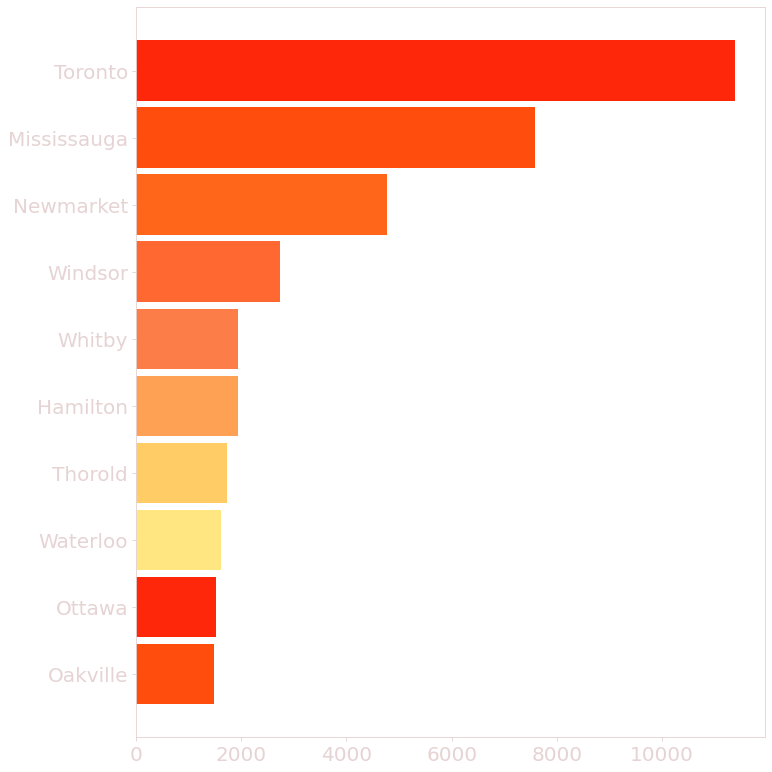

In [47]:
recent_top_10_phu = com.get_category_count(recent_cases,'Reporting_PHU_City',total_cases)
recent_top_10_phu = recent_top_10_phu.head(10)
filename = 'static/images/bar/ontario-reporting_phu_city-top10-recent.png'
chs.graph_bar(recent_top_10_phu,'reporting_phu_city','count','title',theme,filename,figsize = (10,10),font=18,save=1,rolling=2,tr=0)

In [48]:
end = time.time()
job_time = round((end - start),3)

print(job_time)

26.882
